# SSNE Miniproject 4
### 318703 Tomasz Owienko
### 318718 Anna Schäfer
### Grupa piątek

In [96]:
import os
from typing import Any, Callable

import PIL.Image
import pandas as pd
import torch
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import math

In [86]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

In [87]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_float32_matmul_precision('medium')

In [88]:
class ImagesDataModule(pl.LightningDataModule):
    class FastDataset(Dataset):
        def __init__(self, data, labels, num_classes):
            self.dataset = data
            self.labels = labels
            self.number_classes = num_classes

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, index):
            return self.dataset[index], self.labels[index]

    def __init__(self, path: str, transform: Callable[[Any], torch.Tensor], *, val_fraction: float,
                 test_fraction: float, in_memory=False):
        super().__init__()
        assert 0 <= val_fraction + test_fraction <= 1
        assert val_fraction * test_fraction >= 0

        self.image_folder = ImageFolder(path, transform=transform)
        self.dataset: ImagesDataModule.FastDataset | None = None
        self._val_fraction = val_fraction
        self._test_fraction = test_fraction
        self._in_memory = in_memory

        self._train = self._val = self._test = None

    def prepare_data(self) -> None:
        if self._in_memory:
            loader = DataLoader(self.image_folder, batch_size=len(self.image_folder))
            data = next(iter(loader))
            dataset = ImagesDataModule.FastDataset(data[0], data[1], num_classes=len(self.image_folder.classes))
        else:
            dataset = self.image_folder

        val_size = int(len(dataset) * self._val_fraction)
        test_size = int(len(dataset) * self._test_fraction)
        train_size = len(dataset) - val_size - test_size

        self._train, self._val, self._test = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(self._train, batch_size=1024, shuffle=True, num_workers=8 if not self._in_memory else 0, pin_memory=True)

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self._val, batch_size=64, shuffle=False, num_workers=8 if not self._in_memory else 0, pin_memory=True)

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self._test, batch_size=64, shuffle=False, num_workers=8 if not self._in_memory else 0, pin_memory=True)

In [89]:
transform = transforms.Compose([
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5)),
])

dm = ImagesDataModule('trafic_32', transform, val_fraction=0.1, test_fraction=0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


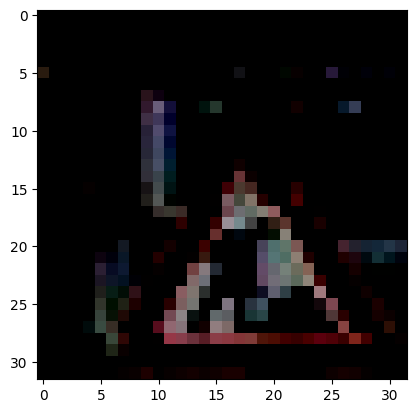

In [104]:
train_dataloader = dm.train_dataloader()
images, labels = next(iter(train_dataloader))
plt.imshow(images[1].permute(1, 2, 0).numpy())

In [90]:
import pytorch_lightning as pl

class DiffusionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(3, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 3, kernel_size=5, padding=2),
            ]
        )
        self.act = nn.SiLU()  # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x)
                x = self.downscale(x)

        for i, l in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x += h.pop()
            x = self.act(l(x))

        return x
    
    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log('train_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=0.001)
        return optimizer

In [91]:
model = DiffusionModel()

checkpoint_callback = ModelCheckpoint(
    save_top_k=10,
    monitor="val_loss",
    mode="min",
    filename="checkpoint-{epoch:02d}-{val_loss:.2f}",
)

trainer = pl.Trainer(max_epochs=40, callbacks=[checkpoint_callback])
trainer.fit(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | down_layers | ModuleList | 156 K 
1 | up_layers   | ModuleList | 156 K 
2 | act         | SiLU       | 0     
3 | downscale   | MaxPool2d  | 0     
4 | upscale     | Upsample   | 0     
-------------------------------------------
312 K     Trainable params
0         Non-trainable params
312 K     Total params
1.249     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\annak\PycharmProjects\24l-ssne\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
`Trainer.fit` stopped: `max_epochs=40` reached.


In [92]:
model.eval()
with torch.no_grad():
    sample = torch.randn(10, 3, 32, 32)
    generated_images = model(sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

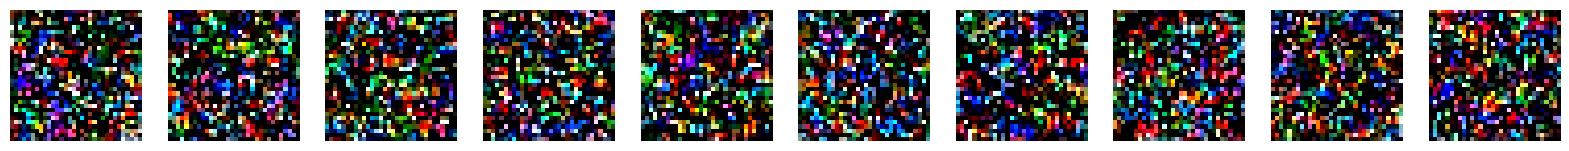

In [93]:
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i, img in enumerate(generated_images):
    axs[i].imshow(img.permute(1, 2, 0).numpy())
    axs[i].axis('off')
plt.show()